# Katona Máté (PD6YOR)

# Homework 3

The maximum score of this homework is 100+20 points. Grading is listed in this table:

| Grade | Score range |
| --- | --- |
| 5 | 85+ |
| 4 | 70-84 |
| 3 | 55-69 |
| 2 | 40-54 |
| 1 | 0-39 |

Most exercises include tests which should pass if your solution is correct.
However, successful tests do not guarantee that your solution is correct.
You are free to add more tests.

## Deadline

Monday, 11 December 2017, 23:59

## Boilerplate

Feel free to copy any boilerplate code you need from labs [9](../../course_material/09_Morphology_lab/09_Morphology_lab.ipynb#Morphology) and [10](../../course_material/10_Syntax/10_Syntax_lab.ipynb#Boilerplate).

In [1]:
# Utility functions
from functools import partial
import os
import subprocess
import tempfile

from IPython.display import display, Image

def execute_commands(*cmds, fancy=True):
    """
    Starts foma end executes the specified commands.
    Might not work if there are too many...
    """
    if fancy:
        print('Executing commands...\n=====================\n')
    args = ' '.join('-e "{}"'.format(cmd) for cmd in cmds)
    output = subprocess.check_output('foma {} -s'.format(args),
                                     stderr=subprocess.STDOUT,
                                     shell=True).decode('utf-8')
    print(output)
    if fancy:
        print('=====================\n')
    
def compile_lexc(lexc_string, fst_file):
    """
    Compiles a string describing a lexc lexicon with foma. The FST
    is written to fst_file.
    """
    with tempfile.NamedTemporaryFile(mode='wt', encoding='utf-8', delete=False) as outf:
            outf.write(lexc_string)
    try:
        execute_commands('read lexc {}'.format(outf.name),
                         'save stack {}'.format(fst_file), fancy=False)
        #!foma -e "read lexc {outf.name}" -e "save stack {fst_file}" -s
    finally:
        os.remove(outf.name)
        
def apply(fst_file, words, up=True):
    """
    Applies the FST in fst_file on the supplied words. The default direction
    is up.
    """
    if isinstance(words, list):
        words = '\n'.join(map(str, words))
    elif not isinstance(words, str):
        raise ValueError('words must be a str or list')
    header = 'Applying {} {}...'.format(fst_file, 'up' if up else 'down')
    print('{}\n{}\n'.format(header, '=' * len(header)))
    invert = '-i' if not up else ''
    result = subprocess.check_output('flookup {} {}'.format(invert, fst_file),
                                     stderr=subprocess.STDOUT, shell=True,
                                     input=words.encode('utf-8'))
    print(result.decode('utf-8')[:-1])  # Skip last newline
    print('=' * len(header), '\n')
       
apply_up = partial(apply, up=True)
apply_down = partial(apply, up=False)

def draw_net(fst_file, inline=True):
    """
    Displays a compiled network inline or in a separate window.
    The package imagemagic must be installed for this function to work.
    """
    !foma -e "load stack {fst_file}" -e "print dot >{fst_file}.dot" -s
    if inline:
        png_data = subprocess.check_output(
            'cat {}.dot | dot -Tpng'.format(fst_file), shell=True)
        display(Image(data=png_data, format='png'))
    else:
        !cat {fst_file}.dot | dot -Tpng | display
    !rm {fst_file}.dot

In [2]:
import graphviz
import nltk
from nltk import Nonterminal
from nltk.parse.generate import generate
from nltk.tree import Tree

def does_tcl_work():
    """Checks if Tcl is installed and works (e.g. it won't on a headless server)."""
    tree = nltk.tree.Tree('test', [])
    try:
        tree._repr_png_()
        return True
    except:
        return False

def draw_tree(tree):
    """Draws an NLTK parse tree via Graphviz."""
    def draw_tree_rec(curr_root, graph, last_node):
        node_id = str(int(last_node) + 1)
        for child in curr_root:
            if isinstance(child, nltk.tree.Tree):
                graph.node(node_id, child.label(), penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = draw_tree_rec(child, graph, node_id)
            else:
                graph.node(node_id, child, penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = str(int(node_id) + 1)
        return str(int(node_id) + 1)
    
    graph = graphviz.Graph()
    graph.graph_attr['ranksep'] = '0.2'
    graph.node('0', tree.label(), penwidth='0')
    draw_tree_rec(tree, graph, '0')
    return graph._repr_svg_()

# Use Graphviz to draw the tree if the Tcl backend of nltk doesn't work
if not does_tcl_work():
    svg_formatter = get_ipython().display_formatter.formatters['image/svg+xml']
    svg_formatter.for_type(nltk.tree.Tree, draw_tree)
    # Delete the nltk drawing function, just to be sure
    delattr(Tree, '_repr_png_')

# Exercise 1: Morphology (45 points)


## 1.1 Extend the lexc grammar (20 points)

This exercise assumes that you have finished the lexc lab exercises. The grammar you hand in have to handle the adjectives listed in the lab exercises, as well as the number (singular / plural), the nominative and accusative cases, comparative and superlative forms, and vowel harmony.

There are two sub-tasks to this exercise. You can download them from
1. http://sandbox.mokk.bme.hu/~ndavid/homework3/{NEPTUN_CODE}/homework3_1_1_1.ipynb
1. http://sandbox.mokk.bme.hu/~ndavid/homework3/{NEPTUN_CODE}/homework3_1_1_2.ipynb

(Note: all letters in the Neptun code must be capitalized.)

Please don't solve the exercises in the downloaded notebooks, but copy the descriptions and starter code snippets to the cells below.

### 1.1.1 Nouns

Extend the grammar with nouns ending with a vowel.

For the first group, the declension requires modification of the root: _**a**_ becomes _**á**_ and _**e**_ becomes _**é**_. For both groups, the linking vowel is the same as for adjectives.

Examples:
- _kutya_ + `[Pl]` $\rightarrow$ _kuty**á**k_
- _kutya_ + `[Acc]` $\rightarrow$ _kuty**á**t_
- _kutya_ + `[Pl]` + `[Acc]` $\rightarrow$ _kuty**á**k**a**t_

Hint: handle the inflected forms first and then find a shortcut for the `[Nom]` case.

In [3]:
nouns_1 = """
kutya ! dog
szalma ! straw
utca ! street
nénike ! little old lady
öntöde ! foundry
pecsenye ! roast
"""

nouns_2 = """
néni ! old lady
tű ! needle
randevú ! date (back)
szajré ! swag (inf, back)
jeti ! yeti
faodú ! tree hollow (back)
"""

In [4]:
grammar = """
Multichar_Symbols 
    ! legesleg[/Supl]piros[/Adj|col]abb[_Comp/Adj]ak[Pl]at[Acc]
    ! nénike[/N]k[Pl]et[Acc]
    [/Supl] [/Adj] [_Cmp/Adj] [Pl] [Acc] [/N]
    @U.HARM.F@ @U.HARM.B@  ! harmony
    @P.EX.T@ @R.EX@ @D.EX@  ! exaggarative 
    @P.SUP.T@ @R.SUP@ @D.SUP@  ! superlative
    @P.VOW.T@ @R.VOW@ @D.VOW@ @C.VOW@  ! vowel ending
    @P.MOD.T@ @P.MOD.F@ @R.MOD.T@ @R.MOD.F@ @D.MOD.T@ @D.MOD.F@ @C.MOD@  ! root modification

LEXICON Root
    @P.VOW.T@     nouns ;  ! in this example, all nouns end with a vowel
                  ex    ;  ! will continue to adjs

LEXICON nouns
    @U.HARM.B@    bnouns     ;
    @U.HARM.B@    bnouns_mod ;
    @U.HARM.F@    fnouns     ;
    @U.HARM.F@    fnouns_mod ;

LEXICON fnouns
    néni          noun_tag ;
    tű            noun_tag ;
    jeti          noun_tag ;

LEXICON bnouns
    randevú       noun_tag ;
    szajré        noun_tag ;
    faodú         noun_tag ;

LEXICON fnouns_mod
    nénik         mod ;
    öntöd         mod ;
    pecseny       mod ;

LEXICON bnouns_mod
    kuty          mod ;
    szalm         mod ;
    utc           mod ;

LEXICON mod
    @U.HARM.B@@P.MOD.F@a:@U.HARM.B@@P.MOD.F@a noun_tag ;
    @U.HARM.B@@P.MOD.T@a:@U.HARM.B@@P.MOD.T@á noun_tag ;
    @U.HARM.F@@P.MOD.F@e:@U.HARM.F@@P.MOD.F@e noun_tag ;
    @U.HARM.F@@P.MOD.T@e:@U.HARM.F@@P.MOD.T@é noun_tag ;

LEXICON noun_tag 
    @R.MOD.F@[/N]:@R.MOD.F@0 # ;  ! only non-modified stems (MOD.F) can stop
    @D.MOD.F@[/N]:@D.MOD.F@0 plur ;

LEXICON ex
    @P.EX.T@leges ex  ;
                  sup ;

LEXICON sup
    @P.SUP.T@leg  sup_tag ;
    @D.EX@        adjs ;

LEXICON sup_tag
    [/Supl]:0    adjs ;

LEXICON adjs
    @U.HARM.F@    fadjs ;
    @U.HARM.B@    badjs ;

LEXICON fadjs
    csendes       adj_tag ;
    egészséges    adj_tag ;
    idős          adj_tag ;
    kék           adj_tag ;
    mély          adj_tag ;
    öntelt        adj_tag ;
    szeles        adj_tag ;
    terhes        adj_tag ;
    zsémbes       adj_tag ;

LEXICON badjs
    abszurd       adj_tag ;
    bájos         adj_tag ;
    finom         adj_tag ;
    gyanús        adj_tag ;
    okos          adj_tag ;
    piros         adj_tag ;
    száraz        adj_tag ;
    zord          adj_tag ;

LEXICON adj_tag
    [/Adj]:0       comp ;

LEXICON comp 
    @D.SUP@       plur;
    @U.HARM.F@ebb comp_tag ;
    @U.HARM.B@abb comp_tag ;

LEXICON comp_tag
    [_Comp/Adj]:0  plur ;

LEXICON plur
                                       case ;
    @R.VOW@@C.VOW@@C.MOD@k             plur_tag ;  ! only with vowel-ending words, but overrides both vowel-ending (C.VOW) and modified stem (C.MOD)
    @D.VOW@@U.HARM.F@ek                plur_tag ;
    @D.VOW@@U.HARM.B@ak                plur_tag ;

LEXICON plur_tag
    [Pl]:0        case ;

LEXICON case
    @D.MOD.T@            # ;  ! modified stems are not allowed to stop
    @R.VOW@@C.VOW@t      case_tag ;
    @D.VOW@@U.HARM.F@et  case_tag ;
    @D.VOW@@U.HARM.B@at  case_tag ;

LEXICON case_tag
    [Acc]:0       # ;
"""

compile_lexc(grammar, 'nouns.fst')

Root...2, nouns...4, fnouns...3, bnouns...3, fnouns_mod...3, bnouns_mod...3, mod...4, noun_tag...2, ex...2, sup...2, sup_tag...1, adjs...2, fadjs...9, badjs...8, adj_tag...1, comp...3, comp_tag...1, plur...4, plur_tag...1, case...4, case_tag...Building lexicon...
1
Determinizing...
Minimizing...
Done!
5.0 kB. 159 states, 205 arcs, Cyclic.
Writing to file nouns.fst.



In [7]:
# draw_net('nouns.fst')
apply_up('nouns.fst', ['nénikét', 'pecsenyék', 'tűket', 'faodú', 'legeslegeslegszárazabbakat', 'legterhesebb'])        
execute_commands('load stack nouns.fst', 'print upper-words')

Applying nouns.fst up...

nénikét	nénike[/N]t[Acc]

pecsenyék	pecsenye[/N]k[Pl]

tűket	tű[/N]k[Pl]et[Acc]

faodú	faodú[/N]

legeslegeslegszárazabbakat	legeslegesleg[/Supl]száraz[/Adj]abb[_Comp/Adj]ak[Pl]at[Acc]

legterhesebb	leg[/Supl]terhes[/Adj]ebb[_Comp/Adj]


Executing commands...

5.0 kB. 159 states, 205 arcs, Cyclic.
kutya[/N]t[Acc]
kutya[/N]k[Pl]at[Acc]
kutya[/N]k[Pl]
kutya[/N]
randevú[/N]t[Acc]
randevú[/N]k[Pl]at[Acc]
randevú[/N]k[Pl]
randevú[/N]
utca[/N]t[Acc]
utca[/N]k[Pl]at[Acc]
utca[/N]k[Pl]
utca[/N]
szajré[/N]t[Acc]
szajré[/N]k[Pl]at[Acc]
szajré[/N]k[Pl]
szajré[/N]
szalma[/N]t[Acc]
szalma[/N]k[Pl]at[Acc]
szalma[/N]k[Pl]
szalma[/N]
faodú[/N]t[Acc]
faodú[/N]k[Pl]at[Acc]
faodú[/N]k[Pl]
faodú[/N]
tű[/N]t[Acc]
tű[/N]k[Pl]et[Acc]
tű[/N]k[Pl]
tű[/N]
nénike[/N]t[Acc]
nénike[/N]k[Pl]et[Acc]
nénike[/N]k[Pl]
nénike[/N]
néni[/N]t[Acc]
néni[/N]k[Pl]et[Acc]
néni[/N]k[Pl]
néni[/N]
jeti[/N]t[Acc]
jeti[/N]k[Pl]et[Acc]
jeti[/N]k[Pl]
jeti[/N]
pecsenye[/N]t[Acc]
pecsenye[/N]k[Pl]et[Acc]
pecse

### 1.1.2 The allative case

Extend the grammar with the allative case. This case differs from accusative in two ways:
- it never gets a linking vowel
- it has three forms (_-hoz_ / _-hez_ / _-höz_). The first two are used for the words you would expect. The third one is used for words which takes front-vowel inflections, but whose last vowel is a _**ö**_ or _**ő**_ (yes, there is only one of those in the lab word lists).

Examples:
- _finom_ + `[All]` $\rightarrow$ _finom**hoz**_
- _mély_ + `[All]` $\rightarrow$ _mély**hez**_
- _idős_ + `[All]` $\rightarrow$ _idős**höz**_

Also add the following adjectives to the grammar.

In [ ]:
adjectives = """
bűnös ! sinful
ösztönös ! instinctive
felnőtt ! adult
dühös ! angry
erős ! strong
"""

In [8]:
grammar = """
Multichar_Symbols 
    ! erős[/Adj]höz[All]	
    [/Supl] [/Adj] [_Comp/Adj] [Pl] [Acc]
    @P.HARM.F@ @P.HARM.B@ @P.HARM.O@ @D.HARM.B@ @R.HARM.F@ @R.HARM.B@ @R.HARM.O@  ! harmony
    @P.EX.T@ @R.EX@ @D.EX@  ! exaggarative
    @P.SUP.T@ @R.SUP@ @D.SUP@  ! superlative

LEXICON Root
                  ex    ;  ! will continue to adjs

LEXICON ex
    @P.EX.T@leges ex  ;
                  sup ;

LEXICON sup
    @P.SUP.T@leg  sup_tag ;
    @D.EX@        adjs ;

LEXICON sup_tag
    [/Supl]:0    adjs ;

LEXICON adjs
    @P.HARM.F@    fadjs ;
    @P.HARM.B@    badjs ;
    @P.HARM.O@    oadjs ;

LEXICON fadjs
    csendes       adj_tag ;
    egészséges    adj_tag ;
!    idős          adj_tag ;  ! moved to oeadjs
    kék           adj_tag ;
    mély          adj_tag ;
    öntelt        adj_tag ;
    szeles        adj_tag ;
    terhes        adj_tag ;
    zsémbes       adj_tag ;

LEXICON badjs
    abszurd       adj_tag ;
    bájos         adj_tag ;
    finom         adj_tag ;
    gyanús        adj_tag ;
    okos          adj_tag ;
    piros         adj_tag ;
    száraz        adj_tag ;
    zord          adj_tag ;

LEXICON oadjs
    idős          adj_tag ;
    bűnös         adj_tag ;
    ösztönös      adj_tag ;
    felnőtt       adj_tag ;
    dühös         adj_tag ;
    erős          adj_tag ;

LEXICON adj_tag
    [/Adj]:0       comp ;

LEXICON comp 
    @D.SUP@                 plur;
    @D.HARM.B@@P.HARM.F@ebb comp_tag ;
    @R.HARM.B@abb           comp_tag ;

LEXICON comp_tag
    [_Comp/Adj]:0  plur ;

LEXICON plur
                                case ;
    @D.HARM.B@@P.HARM.F@ek      plur_tag ;
    @R.HARM.B@ak                plur_tag ;

LEXICON plur_tag
    [Pl]:0        case ;

LEXICON case
                   # ;
    @R.HARM.F@hez  all_tag ;
    @R.HARM.B@hoz  all_tag ;
    @R.HARM.O@höz  all_tag ;
    @D.HARM.B@et   acc_tag ;
    @R.HARM.B@at   acc_tag ;

LEXICON acc_tag
    [Acc]:0       # ;

LEXICON all_tag
    [All]:0       # ;
"""

compile_lexc(grammar, 'allative.fst')

Root...1, ex...2, sup...2, sup_tag...1, adjs...3, fadjs...8, badjs...8, oadjs...6, adj_tag...1, comp...3, comp_tag...1, plur...3, plur_tag...1, case...6, acc_tag...1, all_tag...Building lexicon...
1
Determinizing...
Minimizing...
Done!
4.0 kB. 122 states, 156 arcs, Cyclic.
Writing to file allative.fst.



In [11]:
# draw_net('allative.fst')
apply_up('allative.fst', ['erősebbekhez', 'erőshöz', 'legeslegeslegpirosabbhoz', 'kéket'])        
execute_commands('load stack allative.fst', 'print upper-words')

Applying allative.fst up...

erősebbekhez	erős[/Adj]ebb[_Comp/Adj]ek[Pl]hez[All]

erőshöz	erős[/Adj]höz[All]

legeslegeslegpirosabbhoz	legeslegesleg[/Supl]piros[/Adj]abb[_Comp/Adj]hoz[All]

kéket	kék[/Adj]et[Acc]


Executing commands...

4.0 kB. 122 states, 156 arcs, Cyclic.
terhes[/Adj]ebb[_Comp/Adj]
terhes[/Adj]ebb[_Comp/Adj]et[Acc]
terhes[/Adj]ebb[_Comp/Adj]ek[Pl]
terhes[/Adj]ebb[_Comp/Adj]ek[Pl]et[Acc]
terhes[/Adj]ebb[_Comp/Adj]ek[Pl]hez[All]
terhes[/Adj]ebb[_Comp/Adj]hez[All]
terhes[/Adj]
terhes[/Adj]et[Acc]
terhes[/Adj]ek[Pl]
terhes[/Adj]ek[Pl]et[Acc]
terhes[/Adj]ek[Pl]hez[All]
terhes[/Adj]hez[All]
egészséges[/Adj]ebb[_Comp/Adj]
egészséges[/Adj]ebb[_Comp/Adj]et[Acc]
egészséges[/Adj]ebb[_Comp/Adj]ek[Pl]
egészséges[/Adj]ebb[_Comp/Adj]ek[Pl]et[Acc]
egészséges[/Adj]ebb[_Comp/Adj]ek[Pl]hez[All]
egészséges[/Adj]ebb[_Comp/Adj]hez[All]
egészséges[/Adj]
egészséges[/Adj]et[Acc]
egészséges[/Adj]ek[Pl]
egészséges[/Adj]ek[Pl]et[Acc]
egészséges[/Adj]ek[Pl]hez[All]
egészséges[/Adj]hez[All]
önte

## 1.2 CFG morphology (25 points)

### 1.2.1 The basics (15 points)

Implement morphological analysis with a CFG grammar. Requirements:
- the grammar should handle everything we covered in the lab, except for vowel harmony
- there is no need to handle generation; concentrate on parsing
- it doesn't matter what the intermediate nonterminals are called. Ideally, _preterminals_ should be valid morphological tags, as in the example below; however, `nlkt.CFG.fromstring()` cannot parse tags such as `[Acc]` as nonterminals. You are free to call them whatever you wish, but descriptive names are encouraged.
- encapsulate the functionality in a `CFGMorphParser` class:
    - its `__init__()` should accept no parameters (or at least provide defaults)
    - it should have a `parse_tree()` method, which accepts a word and returns the parse tree
    - it should have a `parse()` method, which accepts a word and returns the morphological parse _in the same form as HFST_. Refer to `hfst_lookup` and the tests for the format. `nltk.tree.Tree.pos()` is a good starting point

Note that having the same format as HFST doesn't mean you have to return the exact same output: for instance, we defined _terhes_ as a genuine adjective, even though it is derived from the noun _teher_. So HFST would analyze it as `teher[/N]es[_Adjz:s/Adj][Nom]`, but you only need to return `terhes[/Adj]`. You **also don't have to cover [Nom]**, because of [this bug](https://github.com/nltk/nltk/issues/1890).

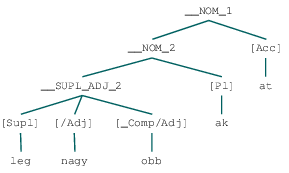

In [3]:
import nltk
from nltk.tree import Tree

tree = Tree('__NOM_1', [
    Tree('__NOM_2', [
        Tree('__SUPL_ADJ_2', [
            Tree('[Supl]', ['leg']),
            Tree('[/Adj]', ['nagy']),
            Tree('[_Comp/Adj]', ['obb']),
        ]),
        Tree('[Pl]', ['ak']),
    ]),
    Tree('[Acc]', ['at']),
])

display(tree)
# If display() doesn't work, try this
# tree.pretty_print()

None
terhes[/Adj]
csendes[/Adj]ebb[_Comp/Adj]et[Acc]
leg[/Supl]finom[/Adj]abb[_Comp/Adj]ak[Pl]
legesleg[/Supl]finom[/Adj]abb[_Comp/Adj]ek[Pl]


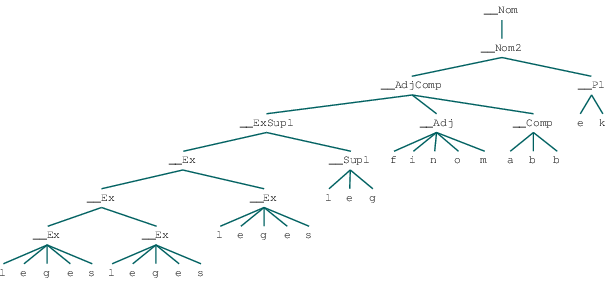

In [8]:
# Your implementation here


# based on nltk.tree.Tree.pos
def pos(tree):
    p = []
    for child in tree:
        if isinstance(child, Tree):
            p.extend(pos(child))
        else:
            return ''.join(tree.leaves()) + tree.label()
    return p

    
class CFGMorphParser(object):
    tag_map = {
        '__Acc': '[Acc]',
        '__Pl': '[Pl]',
        '__Comp': '[_Comp/Adj]',
        '__Adj': '[/Adj]',
        '__Supl': '[/Supl]',
        '__Ex': '',
    }
    
    def __init__(self):
        self.grammar = nltk.CFG.fromstring("""
        __Nom -> __Nom2 __Acc | __Nom2
        __Nom2 -> __AdjComp __Pl | __AdjComp
        __AdjComp -> __ExSupl __Adj __Comp | __Adj __Comp | __Adj
        __ExSupl -> __Ex __Supl | __Supl
        __Ex -> __Ex __Ex | 'l' 'e' 'g' 'e' 's'
        __Supl -> 'l' 'e' 'g'
        __Adj -> 't' 'e' 'r' 'h' 'e' 's' | 'c' 's' 'e' 'n' 'd' 'e' 's' | 'f' 'i' 'n' 'o' 'm'
        __Comp -> 'a' 'b' 'b' | 'e' 'b' 'b'
        __Pl -> 'a' 'k' | 'e' 'k'
        __Acc -> 'a' 't' | 'e' 't'
        """)
        self.p = nltk.ChartParser(self.grammar)
        
    def parse_tree(self, word):
        try:
            trees = self.p.parse(word)
        except ValueError as e:
            return None
        for tree in trees:
            return tree
    
    def parse(self, word):
        tree = self.parse_tree(word)
        if tree is None: 
            return None
        morph = ''.join(pos(tree))
        # replace tags with hfst equivalent
        for t, p in self.tag_map.items():
            morph = morph.replace(t, p)
        return morph
        
    
# Tests
parser = CFGMorphParser()

print(parser.parse('unknown_word'))
print(parser.parse('terhes'))
print(parser.parse('csendesebbet'))
print(parser.parse('legfinomabbak'))
print(parser.parse('legeslegfinomabbek'))
display(parser.parse_tree('legeslegeslegeslegfinomabbak'))

assert parser.parse('unknown_word') is None
assert parser.parse('terhes') == 'terhes[/Adj]'
assert parser.parse('csendesebbet') == 'csendes[/Adj]ebb[_Comp/Adj]et[Acc]'
assert parser.parse('legfinomabbak') == 'leg[/Supl]finom[/Adj]abb[_Comp/Adj]ak[Pl]'
# It's OK here
assert parser.parse('legfinomabbek') == 'leg[/Supl]finom[/Adj]abb[_Comp/Adj]ek[Pl]'

<span style="color:green">Very nice. The only small problem is that "_legesleges_" is not supported.</span>

### 1.2.2 Vowel harmony (10 points)

Also handle vowel harmony. Write a function that traverses the tree manually (similarly to [exercise 2.4 in the lab](../../course_material/10_Syntax/10_Syntax_lab_solutions.ipynb#2.4-Evaluation*)) and returns `True` or `False`, depending on whether the tree conforms to vowel harmony rules. Use this function in `parse_tree` (and `parse`) to filter invalid trees.

In [ ]:
# Tests
assert parser.parse('legfinomabbak') == 'leg[/Supl]finom[/Adj]abb[_Comp/Adj]ak[Pl]'
assert parser.parse('legfinomabbek') == None

# Exercise 2: Syntax (55 points)

In this exercise, you will parse a treebank, and induce a PCFG grammar from it. You will then implement a probabilistic version of the CKY algorithm, and evaluate the grammar on the test split of the treebank.

## 2.1 Parse a treebank (10 points)

Parse the treebank file `en_lines-ud-train.s` in the notebook's directory. Write a **generator** function that reads the file and yields `nltk.tree.Tree` objects. In particular,
- do not read the whole file into memory
- the `Tree.fromstring()` function converts an s-expression into a tree

Open the file in an editor to see the formatting.

Note that the file was created by parsing the [LinES dependency corpus](https://github.com/UniversalDependencies/UD_English-LinES/tree/master) with [Stanford CoreNLP](https://stanfordnlp.github.io/CoreNLP/), so it is not a gold standard by any means, but it will suffice for now.

In [17]:
from nltk.tree import Tree

def parse_treebank(treebank_file):
    with open(treebank_file, 'r') as f:
        s = ''
        for l in f:
            if len(l) > 1:
                s += l
            elif s:
                try:
                    t = Tree.fromstring(s)
                except ValueError:
                    continue
                finally:
                    s = ''
                yield t
            else:
                s = ''
            
# Tests
assert sum(1 for _ in parse_treebank('en_lines-ud-train.s')) == 2613
assert isinstance(next(parse_treebank('en_lines-ud-train.s')), Tree)

<span style="color:green">OK.</span>

## 2.2 Filter trees (5 points)

In order to avoid problems further down the line, we shall only handle a subset of the trees in the treebank. We call a tree _valid_, if
- its root is `'S'`
- the root has at least two children.

Write a function that returns `True` for "valid" trees and `False` for invalid ones. Filter the your generator with it.

In [18]:
def is_tree_valid(tree):
    if not isinstance(tree, Tree):
        return False
    if tree.label() != 'S':
        return False
    if len(tree) < 2:
        return False
    return True

# Tests
assert sum(map(is_tree_valid, parse_treebank('en_lines-ud-train.s'))) == 2311

## 2.3 Induce the PCFG grammar (10 points)

Now that you have the trees, it is time to induce (train) a PCFG grammar for it! Luckily, `nltk` has a functions for just that: [`nltk.grammar.induce_pcfg`](http://www.nltk.org/api/nltk.html#nltk.grammar.induce_pcfg). Use it to acquire your PCFG grammar. You can find hints at how to use it in the [grammar module](http://www.nltk.org/_modules/nltk/grammar.html).

Note: since we want to parse sentences with the PCKY algorithm, we need our grammar to be in CNF. Unfortunately, `nlkt` cannot convert a grammar to CNF, so you have to ensure that the trees are in CNF before feeding them to the PCFG induction function. That way, we can be sure that our grammar will be also. There are two functions that ensure a tree is in CNF:
- [`collapse_unary`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.collapse_unary). Make sure you call it with `collapsePOS=True`!
- [`chomsky_normal_form`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.chomsky_normal_form). Do not use any smoothing.

In [19]:
def train_grammar(trees):
    prods = []
    for tree in trees: 
        tree.collapse_unary(collapsePOS=True)
        tree.chomsky_normal_form()
        prods += tree.productions()
    return nltk.grammar.induce_pcfg(nltk.Nonterminal('S'), prods)
        
def is_grammar_cnf(grammar):
    for prod in grammar.productions():
        rhs = prod.rhs()
        if len(rhs) > 2 or (len(rhs) == 1 and isinstance(rhs[0], nltk.Nonterminal)):
            return False
    return True

# Tests
grammar = train_grammar(filter(is_tree_valid, parse_treebank('en_lines-ud-train.s')))
assert is_grammar_cnf(grammar)
assert len(grammar.productions()) == 15000

## 2.4 Implement PCKY (15 points)

Implement the PCKY algorithm. Encapsulate it in a class called `PCKYParser`. Extend your `CKYParser` solution from the lab so that it creates trees with probabilities (`ProbabilisticTree`). The `parse()` method should also accept a parameter `n`, and only return the most probable `n` trees (as a generator).

Some pointers:
- [ProbabilisticTree](http://www.nltk.org/api/nltk.html#nltk.tree.ProbabilisticTree), which inherits from
- [ProbabilisticMixIn](http://www.nltk.org/api/nltk.html#nltk.probability.ProbabilisticMixIn)

In [20]:
import numpy as np
from nltk.tree import ProbabilisticTree as PTree
from collections import deque


class PCKYParser(object):
    def __init__(self, grammar):
        if not isinstance(grammar, nltk.CFG):
            raise TypeError("g")
        self.grammar = grammar
        # save some time by separating lexical and production rules
        self.lexicals = [prod for prod in self.grammar.productions() if len(prod.rhs()) == 1]
        self.productions = [prod for prod in self.grammar.productions() if len(prod.rhs()) == 2]
    
    def parse(self, sent, n=1):
        k = len(sent)
        # init
        cky = np.empty((k,k), dtype=object)
        for i in range(k):
            for j in range(k):
                cky[i, j] = []
        # lexical rules
        for i, word in enumerate(sent):
            for lex in self.lexicals:
                if word in lex.rhs():
                    cky[i, i].append(PTree(lex.lhs(), [word], prob=lex.prob()))
        # production rules
        for col in range(1, k):
            for row in range(col-1, -1, -1):
                ways_to_split = col-row  # "distance" from diag
                for w in range(ways_to_split):
                    left = ways_to_split - w
                    down = 1 + w
                    for prod in self.productions:
                        # because of CNF, all non-lexical rules have 2 constituents on rhs
                        ls = prod.rhs()[0]  # left symbol
                        ds = prod.rhs()[1]  # down symbol
                        for lt in cky[row, col-left]:  # left tree
                            for dt in cky[row+down, col]:  # right tree
                                if lt.label() == ls and dt.label() == ds:
                                    # multiply tree and production probabilities
                                    p = lt.prob() * dt.prob() * prod.prob()
                                    cky[row, col].append(PTree(prod.lhs(), [lt, dt], prob=p))
        # collect sentences from parsed trees, sort them by probability
        sents = sorted(
            [tree for tree in cky[0, k-1] if tree.label() == nltk.Nonterminal('S')],
            key=lambda tree: tree.prob()
        )
        # yield the most probable n trees
        for sent in deque(sents, maxlen=n):
            yield sent

In [21]:
grammar = train_grammar(filter(is_tree_valid, parse_treebank('en_lines-ud-train.s')))

In [2]:
# tests
pparser = PCKYParser(grammar)
trees = pparser.parse('A user writes'.split(), n=3)
print('all trees:')
for tree in trees:
    print(tree)
    display(tree)
print('-'*80)
# let's see if it returns the most probable tree when n=1
trees = pparser.parse('A user writes'.split(), n=1)
print('most probable tree:')
for tree in trees:
    print(tree)
    display(tree)

NameError: name 'PCKYParser' is not defined

<span style="color:green">Great! Once sorted, though, you could have just returned `sents[:n]`, no point in used the `deque`.</span>

<span style="color:green">Also, you have realized yourself that it is slow. It is possible to call `grammar.productions()` with the `rhs=XXX` keyword, in which case it does the lookup for you, so that it isn't that slow. Alternatively, you could have created a dictionary that does it for you: just enumerating all 15000 rules won't cut it speedwise, that's for sure.</span>

## 2.5 Evaluate the grammar (15 points)

Evaluate your grammar on the test split of the treebank (`en_lines-ud-dev.s`). Implement the **unlabelled** PARSEVAL metric. See [the first answer for an example](https://linguistics.stackexchange.com/questions/1873/is-there-a-well-established-metric-to-measure-the-effectiveness-of-a-parsing-alg).

In [23]:
def constituents(tree):
    consts = []
    if isinstance(tree, Tree) and isinstance(tree[0], Tree):
        consts.append(' '.join(tree.leaves()))
        for subtree in tree:
            c = constituents(subtree)
            if type(c) is str:
                consts.append(c)
            else:
                consts += c
    else:
        consts = tree[0]
    return consts

In [1]:
# test
# for tree in pparser.parse('A user writes'.split(), n=1):
for tree in pparser.parse('A user writes something on paper with a pen'.split(), n=2):
    print(constituents(tree))

NameError: name 'pparser' is not defined

In [27]:
def parseval_tree(gold, cand):
    gold_consts = constituents(gold)
    cand_consts = constituents(cand)
    correct_cand = [c for c in cand_consts if c in gold_consts]
    correct_gold = [c for c in gold_consts if c in cand_consts]
    precision = len(correct_cand) / len(cand_consts)
    recall = len(correct_gold) / len(gold_consts)
    F = 2 * (precision * recall) / (precision + recall)
    return precision, recall, F
    

def parseval(gold_trees, parser):
    ps, rs, Fs = [], [], []
    # get values for each sentence
    for gold_tree in gold_trees:
        sentence = gold_tree.leaves()
        if len(sentence) > 5: 
            # long sentences take ages to parse
            continue
        try:
            cand_tree = next(parser.parse(sentence, n=1))
            p, r, F = parseval_tree(gold_tree, cand_tree)
        except StopIteration:
            p, r, F = 0.0, 0.0, 0.0
        ps.append(p)
        rs.append(r)
        Fs.append(F)
    # return averages
    return [sum(v) / len(v) for v in [ps, rs, Fs]]

In [28]:
from time import time

gold_trees = filter(is_tree_valid, parse_treebank('en_lines-ud-dev.s'))
pparser = PCKYParser(grammar)
t = time()
ap, ar, aF = parseval(gold_trees, pparser)

print('evaluation time: ', time()-t, 's\n')
print('average precision:', ap)
print('average recall:', ar)
print('average F-score:', aF)

evaluation time:  12.922845602035522 s

average precision: 0.46927689594356276
average recall: 0.5555555555555556
average F-score: 0.508375230434054


<span style="color:green">Great!</span>

# Exercise 3: Bonus* (20 points)

Implement a class that converts Python-style regular expressions to XSLT-style ones, and executes them via foma.

## 3.1 Conversion* (10 points)

The functionality should be encapsulated in a class called `FomaRegex`. The public API specification is as follows:
- its constructor should accept a valid Python regex string (not a [regex object](https://docs.python.org/3/library/re.html#regular-expression-objects)), convert it to the XFST format and store it in its `pattern` member field
- it should have a `convert` static method that does the pattern conversion. You can use pure Python or better yet, a CFG grammar
- the class should implement the context manager protocol:
    - when entering the context, an FSA file should be created via foma and its name stored in the `fsa_file` field.  The [`regex <regex> ;` command](https://github.com/mhulden/foma/blob/master/foma/docs/simpleintro.md#compiling-regular-expressions) can be used to compile a regex in foma; for the rest, refer to the [`compile_lexc()` function](../../course_material/09_Morphology_lab/09_Morphology_lab_solutions.ipynb#Morphology)
    - after the context closes, the FSA file should be deleted and the `fsa_file` member set to `None`

You only need to account for the first six rows in [the table comparing the two syntaxes](../../course_material/08_Morphology/08_Morphology_lecture.ipynb#XFST-vs-Python-regular-expressions). Additionally, you only need to cover the characters a-zA-Z0-9 (i.e. no punctuation). Note that there are two options for verbatim texts in XFST: `[a b c]` or `{abc}`. You are encouraged to use the latter; should you choose to use the former, update the assert statements accordingly.

You don't have to worry about applying the regex at this point.

In [ ]:
import os

class FomaRegex:
    pass

# Tests
assert FomaRegex.convert('ab?c*d+') == '{a}{b}^<2{c}*{d}+'
assert FomaRegex.convert('a.b') == '{a}?{b}'
assert FomaRegex.convert('a+(bc|de).*') == '{a}+[{bc}|{de}]?*'

with FomaRegex('a.b') as fr:
    assert fr.pattern == '{a}?{b}', 'Invalid pattern'
    assert fr.fsa_file is not None, 'FSA file is None in with'
    fsa_file = fr.fsa_file
assert fr.fsa_file is None, 'FSA file is not None after with'
assert not os.path.isfile(fsa_file), 'FSA file still exists after with'

## 3.2 Application* (5 points)

Add a `match` method to the class that runs the regex against the specified string. It should return `True` or `False` depending on whether the regex matched the string.

Note: obviously you should use your FSA file and foma, not the `re` module. :)

In [ ]:
# Tests
with FomaRegex('a*(bc|de).+') as fr:
    assert fr.match('aabcd') is True
    assert fr.match('ade') is False

## 3.3 Multiple regexes (5 points)

Make sure not all `FomaRegex` objects use the same FSA file.

In [ ]:
# Tests
with FomaRegex('a') as a, FomaRegex('b') as b:
    assert a.fsa_file != b.fsa_file